# Marginal Standard Error Rule for transient regime detection and truncation on Grand Canonical Monte Carlo simulations

To eliminate the use of equilibration cycles the **Marginal Standard Error Rule (MSER)** was applied to automatically detect the ideal truncation point to take the average only over the equilibrated region of the adsorption data. This methodology has the advantage that it can be used regardless of the nature of the analyzed data and only requires that there is an ideal truncation point in the data without the need to manually or arbitrarily adjust parameters. There are four variants of MSER:
    
**1.** The original MSER proposed by [White (1997)](https://doi.org/10.1177/003754979706900601) determines the length of the equilibration period after having collected $Y_0, ..., Y_{n-1}$ samples, thus determining the optimal truncation point $\hat{d}(n)$, by solving the minimization problem:

$$
        \hat{d}(n) =  \underset{0 \leq k \leq n-2}{\mathrm{arg\,min}} \, g_n(k)
$$
    
where

$$
        g_n(k) = \frac{1}{(n - k)^2} \sum_{j=k}^{n-1}(Y_j - \bar{Y}_{n,k})^2 = \frac{S^2_{n,k}}{n-k}
$$
    

**2.** The MSER-m variant deals with batches of simulation output ([White et al. 2000](https://doi.org/10.1109/WSC.2000.899843)):**

In particular, it implements MSER on the series given by

$$ \hat{Z}_j = \frac{1}{m}\sum_{l=0}^{m-1} Y_{m(j-1)}, j=1, ..., \left[\frac{n}{m}\right]$$

where _m_ is user-specified. A typical choice is $m=5$. See Hoad and Robinson [2011] and Franklin and White [2008] for more details.


**3.** The [MSER-LLM](https://doi.org/10.1109/WSC.2010.5679163) (**L**eft-most **L**ocal **M**ininum), which identifies the truncation point as the first local minimizer of $g_n(k)$.

**4.** The MSER-LLM-m searches for the left-most local minimum on the *m*-batched data. 

# General use of the MSER functions:

## Import libraries

In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.pymser import pymser

## Read example data

The `example_data` folder presents some adsorption simulation results to test the application of PyMSER.

The `Cu-BTT_500165.0_198.000000.csv` file presents data resulting from a simulation of CO<sub>2</sub> adsorption on Cu-BTC MOF (a.k.a. HKUST-1) at 50 bar (500165 Pa) and 198 K with 50000 cycles.

In [2]:
# Build the file name
file_name = os.path.join('example_data', 'Cu-BTT_500165.0_198.000000.csv')

# Load the .csv file
df = pd.read_csv('example_data/Cu-BTT_500165.0_198.000000.csv')

## Plot raw data

First, lets take a look at the raw data. 

/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


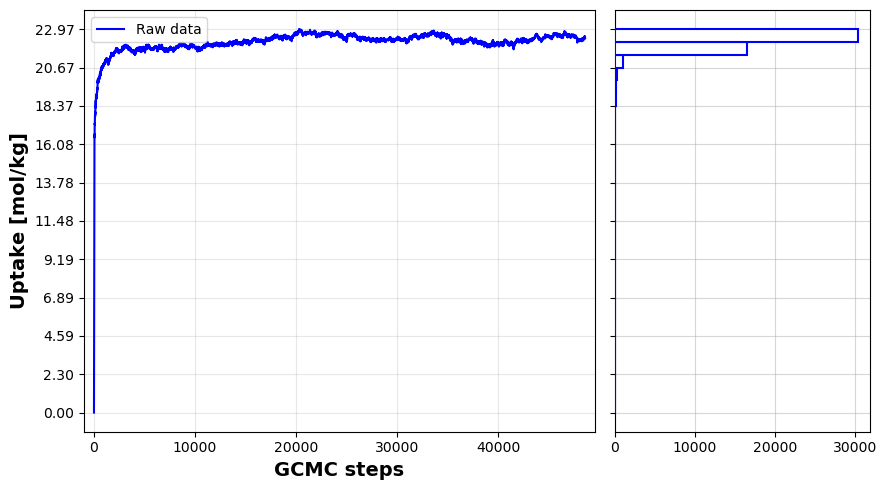

In [3]:
fig, [ax1, ax2] = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, sharey=True)

ax1.set_ylabel("Uptake [mol/kg]", color="black", fontsize=14, fontweight='bold')
ax1.set_xlabel("GCMC steps", fontsize=14, fontweight='bold')
ax1.plot(df['GCMC_step'], df['mol/kg'], label = 'Raw data', color='blue')

ax1.set_yticks(np.arange(0, df['mol/kg'].max()*1.1, df['mol/kg'].max()/10))
ax1.set_xlim(-len(df['mol/kg'])*0.02, len(df['mol/kg'])*1.02)
ax1.tick_params(axis="y", labelcolor="black")

ax1.grid(alpha=0.3)
ax1.legend()

ax2.hist(df['mol/kg'], 
         orientation=u'horizontal', 
         bins=30, 
         edgecolor='blue', 
         lw=1.5, 
         facecolor='white', 
         zorder=3)

ax2.grid(alpha=0.5, zorder=1)

fig.set_size_inches(9,5)
fig.set_dpi(100)
fig.tight_layout()
#fig.savefig('raw_data.png', dpi=300, facecolor='white')
plt.show()

# Applying several variations of MSER to the GCMC data

There are some *flavors* of MSER, and below we will see all of them applied to the same data.

## Original MSER

First, let us apply the standard MSER to obtain the starting index of equilibration (_t0_), the average and standard deviation on the equilibrated data, and some statistics like the autocorrelation time and the number of uncorrelated samples. 

To do this, we just have to apply the `equilibrate` function from the `pymser` package to the data, as exemplified below. When this step is completed you will see the result printed on the screen. If you want to turn off the printing of the result (this may be the case when applied to a large set of data) just adjust the variable `print_results=False`.

The execution may take up to 7 minutes.

In [4]:
start_time = time.time()

results = pymser.equilibrate(df['mol/kg'], LLM=False, batch_size=1, ADF_test=True, print_results=True)

end_time = time.time() - start_time                  

# Print the results
print(f'pyMSER Execution time:               {end_time:.3f} s')

                            pyMSER Equilibration Results
Start of equilibrated data:          13368 of 48613
Total equilibrated steps:            35245  (72.50%)
Average over equilibrated data:      22.4197 ± 0.2105
Number of uncorrelated samples:      22.9
Autocorrelation time:                1067.3

                           Augmented Dickey-Fuller Test
Test statistic for observable: -3.926148246630419
P-value for observable: 0.001850619485090151
The number of lags used: 46
The number of observations used for the ADF regression: 35198
Cutoff Metrics :
  1%: -3.430536 | The data is stationary with 99 % confidence
  5%: -2.861622 | The data is stationary with 95 % confidence
 10%: -2.566814 | The data is stationary with 90 % confidence

pyMSER Execution time:               393.222 s


### Augmented Dickey-Fuller Test

We also applied the Augmented Dickey-Fuller (ADF) Test on the equilibrated data to ensure that this data is statistically stationary. This test only takes about 1 minute, but you can turn it off setting `ADF_test=False`

#### From [Wikipedia](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test):

>In statistics and econometrics, an **augmented Dickey–Fuller test** (ADF) tests the *null hypothesis* that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity. It is an augmented version of the Dickey–Fuller test for a larger and more complicated set of time series models.
>The augmented Dickey–Fuller (ADF) statistic, used in the test, is a negative number. The more negative it is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence.
>The intuition behind the test is that if the series is characterised by a unit root process then the lagged level of the series ($y_{t-1}$) will provide no relevant information in predicting the change in $y_{t}$ besides the one obtained in the lagged changes ($\Delta y_{t-k}$). In this case the $\gamma = 0$ and null hypothesis is not rejected. In contrast, when the process has no unit root, it is stationary and hence exhibits reversion to the mean - so the lagged level will provide relevant information in predicting the change of the series and the null of a unit root will be rejected. 

The results store a dictionary with the data:

- `MSE`: An array with the MSE curve to which the `argmin` rule will be applied to obtain the starting of the equilibrated region;
- `t0`: The starting of the equilibrated region;
- `average`: The average over the equilibrated region;
- `sd`: The standard deviation over the average;
- `equilibrated`: An array with the equilibrated region of the original data;
- `ac_time`: The autocorrelation time;
- `uncorr_samples`: An estimative of the number of uncorrelated samples;

If the Augmented Dickey-Fuller Test is applied (`ADF_test=True`):
- `adf`: Test statistics for observable;
- `pvalue`: P-Value for observable;
- `usedlags`: Number of lags used in the autocorrelation curve;
- `nobs`: The number of observations used for the ADF regression
- `critical_values`: Dictionary containing the critical values for ADF test in intervals of confidence:
  - `1%`:  Threshold for stationarity within 99% confidence
  - `5%`:  Threshold for stationarity within 95% confidence
  - `10%`:  Threshold for stationarity within 90% confidence

**Note**: `adf` should be smaller than the `1%` value for the data to be stationary with 99% confidence, smaller than the `5%` value for the data to be stationary with 95% confidence, and so on.

In [5]:
results

{'MSE': array([9.13546185e-06, 8.92724161e-06, 8.72201315e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 't0': 13368,
 'average': 22.419710963888303,
 'sd': 0.21047024508035234,
 'equilibrated': array([22.15941761, 22.15941761, 22.15941761, ..., 22.44144656,
        22.44144656, 22.44144656]),
 'ac_time': 1067.3173709010946,
 'uncorr_samples': 22.886363636363637,
 'adf': -3.926148246630419,
 'pvalue': 0.001850619485090151,
 'usedlag': 46,
 'n_obs': 35198,
 'critical_values': {'1%': -3.430535799675158,
  '5%': -2.8616221188795743,
  '10%': -2.566813709296144},
 'icbest': -183249.73348132113}

### Plot the results

Now, let us plot the results to visually analyze them. In red, you'll see the equilibrated points and the green line is the average on these points. 

/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


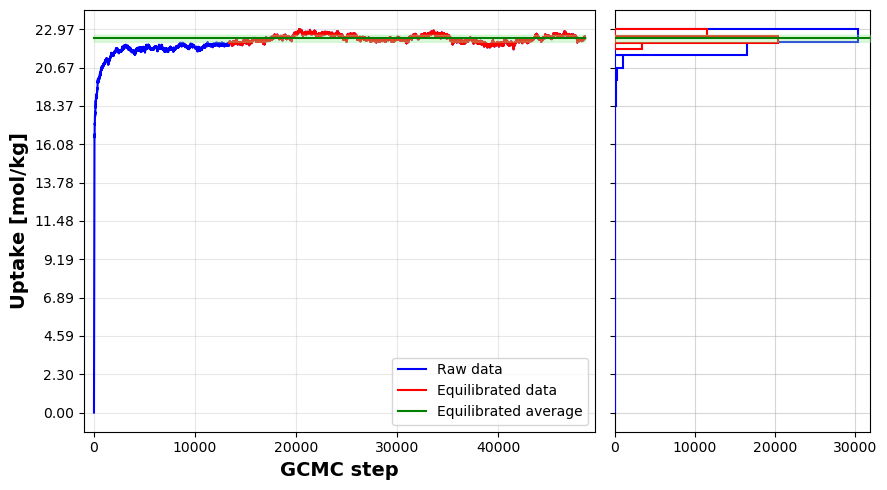

In [6]:
fig, [ax1, ax2] = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, sharey=True)

ax1.set_ylabel("Uptake [mol/kg]", color="black", fontsize=14, fontweight='bold')
ax1.set_xlabel("GCMC step", fontsize=14, fontweight='bold')

ax1.plot(range(len(df['mol/kg'])), 
         df['mol/kg'], 
         label = 'Raw data', 
         color='blue')

ax1.plot(range(len(df['mol/kg']))[results['t0']:], 
         results['equilibrated'], 
         label = 'Equilibrated data', 
         color='red')

ax1.plot([0, len(df['mol/kg'])], 
         [results['average'], results['average']], 
         color='green', zorder=4, 
         label='Equilibrated average')

ax1.fill_between(range(len(df['mol/kg'])), 
                 results['average'] - results['sd'], 
                 results['average'] + results['sd'], 
                 color='lightgreen', alpha=0.3, zorder=4)

ax1.set_yticks(np.arange(0, df['mol/kg'].max()*1.1, df['mol/kg'].max()/10))
ax1.set_xlim(-len(df['mol/kg'])*0.02, len(df['mol/kg'])*1.02)
ax1.tick_params(axis="y", labelcolor="black")

ax1.grid(alpha=0.3)
ax1.legend()

ax2.hist(df['mol/kg'], 
         orientation=u'horizontal', 
         bins=30, 
         edgecolor='blue', 
         lw=1.5, 
         facecolor='white', 
         zorder=3)

ax2.hist(results['equilibrated'], 
         orientation=u'horizontal', 
         bins=3, 
         edgecolor='red', 
         lw=1.5, 
         facecolor='white', 
         zorder=3)

ymax = int(ax2.get_xlim()[-1])

ax2.plot([0, ymax], 
         [results['average'], results['average']],
         color='green', zorder=4, label='Equilibrated average')

ax2.fill_between(range(ymax), 
                 results['average'] - results['sd'],
                 results['average'] + results['sd'],
                 color='lightgreen', alpha=0.3, zorder=4)

ax2.set_xlim(0, ymax)

ax2.grid(alpha=0.5, zorder=1)

fig.set_size_inches(9,5)
fig.set_dpi(100)
fig.tight_layout()
#fig.savefig('MSER_original.png', dpi=300, facecolor='white')
plt.show()

## MSER-*m*

Now, let us apply the MSER-*m* variation of the MSER method. This *flavour* splits the data into batches with size *m* and applies the MSER on the average of the batches. This can considerably speed up the calculations without compromising the results. There is no specific value for *m*, but usually, 5 works pretty well. To use the MSER-*m* flavor we just have to change the value of the `batch_size` parameter on the `equilibrate` function.

The execution may take about 20 seconds.

In [7]:
start_time = time.time()

results = pymser.equilibrate(df['mol/kg'], LLM=False, batch_size=5, ADF_test=True, print_results=True)

end_time = time.time() - start_time                  

# Print the results
print(f'pyMSER Execution time:               {end_time:.3f} s')               

                            pyMSER Equilibration Results
Start of equilibrated data:          13365 of 48613
Total equilibrated steps:            35248  (72.51%)
Average over equilibrated data:      22.4197 ± 0.2105
Number of uncorrelated samples:      22.9
Autocorrelation time:                1067.4

                           Augmented Dickey-Fuller Test
Test statistic for observable: -3.928015034782814
P-value for observable: 0.0018380773527201227
The number of lags used: 46
The number of observations used for the ADF regression: 35201
Cutoff Metrics :
  1%: -3.430536 | The data is stationary with 99 % confidence
  5%: -2.861622 | The data is stationary with 95 % confidence
 10%: -2.566814 | The data is stationary with 90 % confidence

pyMSER Execution time:               17.479 s


**As you can see the results are the same, but the execution time drops from 7 minutes to 20 seconds.**

### Plot the results

Now, let us plot the results to visually analyze them. In red, you'll see the equilibrated points and the green line is the average of these points. 

/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


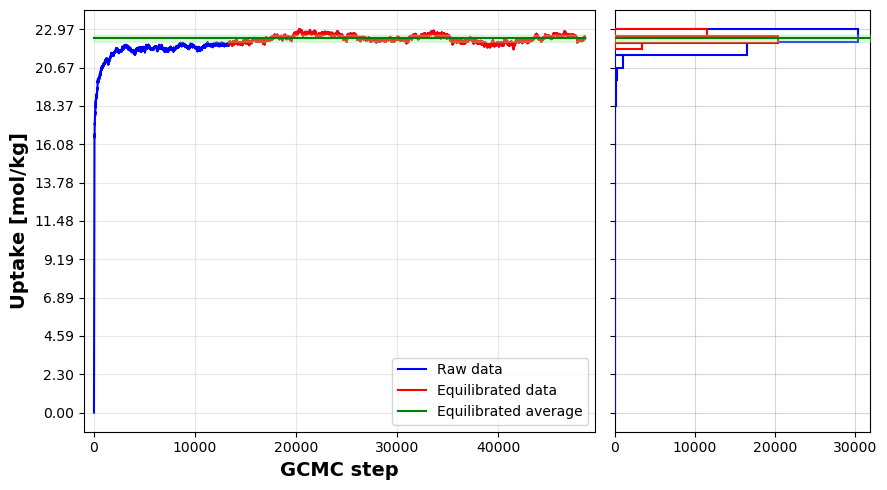

In [8]:
fig, [ax1, ax2] = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, sharey=True)

ax1.set_ylabel("Uptake [mol/kg]", color="black", fontsize=14, fontweight='bold')
ax1.set_xlabel("GCMC step", fontsize=14, fontweight='bold')

ax1.plot(range(len(df['mol/kg'])), 
         df['mol/kg'], 
         label = 'Raw data', 
         color='blue')

ax1.plot(range(len(df['mol/kg']))[results['t0']:], 
         results['equilibrated'], 
         label = 'Equilibrated data', 
         color='red')

ax1.plot([0, len(df['mol/kg'])], 
         [results['average'], results['average']], 
         color='green', zorder=4, 
         label='Equilibrated average')

ax1.fill_between(range(len(df['mol/kg'])), 
                 results['average'] - results['sd'], 
                 results['average'] + results['sd'], 
                 color='lightgreen', alpha=0.3, zorder=4)

ax1.set_yticks(np.arange(0, df['mol/kg'].max()*1.1, df['mol/kg'].max()/10))
ax1.set_xlim(-len(df['mol/kg'])*0.02, len(df['mol/kg'])*1.02)
ax1.tick_params(axis="y", labelcolor="black")

ax1.grid(alpha=0.3)
ax1.legend()

ax2.hist(df['mol/kg'], 
         orientation=u'horizontal', 
         bins=30, 
         edgecolor='blue', 
         lw=1.5, 
         facecolor='white', 
         zorder=3)

ax2.hist(results['equilibrated'], 
         orientation=u'horizontal', 
         bins=3, 
         edgecolor='red', 
         lw=1.5, 
         facecolor='white', 
         zorder=3)

ymax = int(ax2.get_xlim()[-1])

ax2.plot([0, ymax], 
         [results['average'], results['average']],
         color='green', zorder=4, label='Equilibrated average')

ax2.fill_between(range(ymax), 
                 results['average'] - results['sd'],
                 results['average'] + results['sd'],
                 color='lightgreen', alpha=0.3, zorder=4)

ax2.set_xlim(0, ymax)

ax2.grid(alpha=0.5, zorder=1)

fig.set_size_inches(9,5)
fig.set_dpi(100)
fig.tight_layout()
#fig.savefig('MSER_original.png', dpi=300, facecolor='white')
plt.show()

## MSER-LLM

The LLM version selects the **L**eftmost **L**ocal **M**ininum of the MSER curve. This specific version is designed to delete less data than the original MSER with a small impact on the final average. To use this *flavour* we just need to change the `LLM` parameter to `True`.

The execution time should be about 7 minutes, the same as the original MSER.

In [9]:
start_time = time.time()

results = pymser.equilibrate(df['mol/kg'], LLM=True, batch_size=1, ADF_test=True, print_results=True)

end_time = time.time() - start_time                  

# Print the results
print(f'pyMSER Execution time:               {end_time:.3f} s')               

                            pyMSER Equilibration Results
Start of equilibrated data:          2776 of 48613
Total equilibrated steps:            45837  (94.29%)
Average over equilibrated data:      22.2965 ± 0.2982
Number of uncorrelated samples:      13.6
Autocorrelation time:                2342.4

                           Augmented Dickey-Fuller Test
Test statistic for observable: -3.111983100130856
P-value for observable: 0.025679001670561027
The number of lags used: 55
The number of observations used for the ADF regression: 45781
Cutoff Metrics :
  1%: -3.430493 | The data is not stationary with 99 % confidence
  5%: -2.861603 | The data is stationary with 95 % confidence
 10%: -2.566804 | The data is stationary with 90 % confidence

pyMSER Execution time:               386.680 s


As you can see the LLM version delete less data than the previous versions but resulted in fairly the same values for the average uptake. Besides that, the ADF test shows that the data is not stationary with 99% confidence, however, is stationary below 95% confidence. 

### Plot the results

Now, let us plot the results to visually analyze them. In red, you'll see the equilibrated points and the green line is the average of these points. 

/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


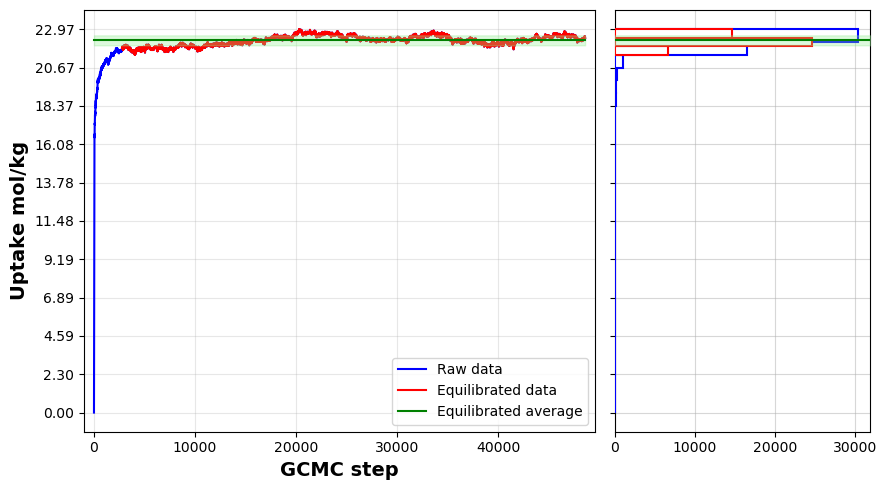

In [10]:
fig, [ax1, ax2] = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, sharey=True)

ax1.set_ylabel("Uptake mol/kg", color="black", fontsize=14, fontweight='bold')
ax1.set_xlabel("GCMC step", fontsize=14, fontweight='bold')

ax1.plot(range(len(df['mol/kg'])), 
         df['mol/kg'], 
         label = 'Raw data', 
         color='blue')

ax1.plot(range(len(df['mol/kg']))[results['t0']:], 
         results['equilibrated'], 
         label = 'Equilibrated data', 
         color='red')

ax1.plot([0, len(df['mol/kg'])], 
         [results['average'], results['average']], 
         color='green', zorder=4, 
         label='Equilibrated average')

ax1.fill_between(range(len(df['mol/kg'])), 
                 results['average'] - results['sd'], 
                 results['average'] + results['sd'], 
                 color='lightgreen', alpha=0.3, zorder=4)

ax1.set_yticks(np.arange(0, df['mol/kg'].max()*1.1, df['mol/kg'].max()/10))
ax1.set_xlim(-len(df['mol/kg'])*0.02, len(df['mol/kg'])*1.02)
ax1.tick_params(axis="y", labelcolor="black")

ax1.grid(alpha=0.3)
ax1.legend()

ax2.hist(df['mol/kg'], 
         orientation=u'horizontal', 
         bins=30, 
         edgecolor='blue', 
         lw=1.5, 
         facecolor='white', 
         zorder=3)

ax2.hist(results['equilibrated'], 
         orientation=u'horizontal', 
         bins=3, 
         edgecolor='red', 
         lw=1.5, 
         facecolor='white', 
         zorder=3)

ymax = int(ax2.get_xlim()[-1])

ax2.plot([0, ymax], 
         [results['average'], results['average']],
         color='green', zorder=4, label='Equilibrated average')

ax2.fill_between(range(ymax), 
                 results['average'] - results['sd'],
                 results['average'] + results['sd'],
                 color='lightgreen', alpha=0.3, zorder=4)

ax2.set_xlim(0, ymax)

ax2.grid(alpha=0.5, zorder=1)

fig.set_size_inches(9,5)
fig.set_dpi(100)
fig.tight_layout()
#fig.savefig('MSER_original.png', dpi=300, facecolor='white')
plt.show()

## MSER-LLM-*m*

Finally, we can combine the advantages of the LLM and the batched versions of MSER. Again, we have to change the value of the `batch_size` to the desired value and activate the `LLM` parameter. 

The execution time should be about 20 seconds.

In [11]:
start_time = time.time()

results = pymser.equilibrate(df['mol/kg'], LLM=True, batch_size=5, ADF_test=True, print_results=True)

end_time = time.time() - start_time                  

# Print the results
print(f'pyMSER Execution time:               {end_time:.3f} s')               

                            pyMSER Equilibration Results
Start of equilibrated data:          2780 of 48613
Total equilibrated steps:            45833  (94.28%)
Average over equilibrated data:      22.2965 ± 0.2982
Number of uncorrelated samples:      13.6
Autocorrelation time:                2341.7

                           Augmented Dickey-Fuller Test
Test statistic for observable: -3.0918528918214423
P-value for observable: 0.027162015419132133
The number of lags used: 55
The number of observations used for the ADF regression: 45777
Cutoff Metrics :
  1%: -3.430493 | The data is not stationary with 99 % confidence
  5%: -2.861603 | The data is stationary with 95 % confidence
 10%: -2.566804 | The data is stationary with 90 % confidence

pyMSER Execution time:               19.242 s


### Plot the results

Now, let us plot the results to visually analyze them. In red, you'll see the equilibrated points and the green line is the average of these points. 

/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


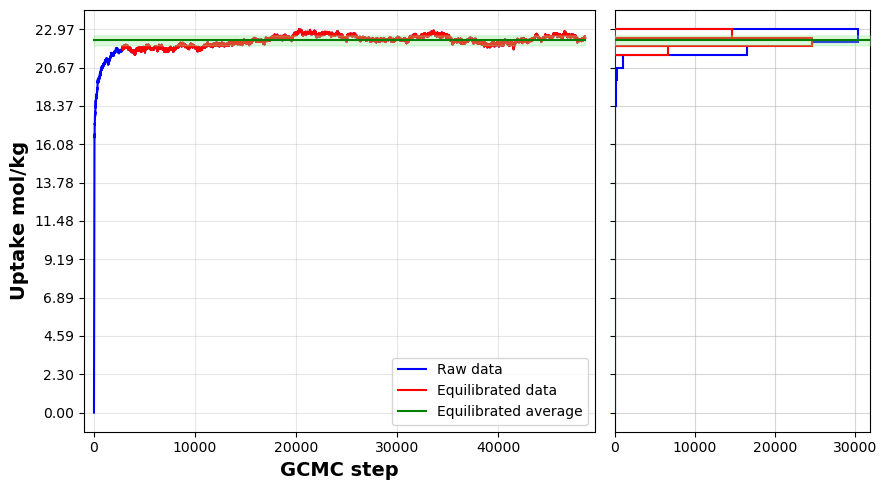

In [12]:
fig, [ax1, ax2] = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, sharey=True)

ax1.set_ylabel("Uptake mol/kg", color="black", fontsize=14, fontweight='bold')
ax1.set_xlabel("GCMC step", fontsize=14, fontweight='bold')

ax1.plot(range(len(df['mol/kg'])), 
         df['mol/kg'], 
         label = 'Raw data', 
         color='blue')

ax1.plot(range(len(df['mol/kg']))[results['t0']:], 
         results['equilibrated'], 
         label = 'Equilibrated data', 
         color='red')

ax1.plot([0, len(df['mol/kg'])], 
         [results['average'], results['average']], 
         color='green', zorder=4, 
         label='Equilibrated average')

ax1.fill_between(range(len(df['mol/kg'])), 
                 results['average'] - results['sd'], 
                 results['average'] + results['sd'], 
                 color='lightgreen', alpha=0.3, zorder=4)

ax1.set_yticks(np.arange(0, df['mol/kg'].max()*1.1, df['mol/kg'].max()/10))
ax1.set_xlim(-len(df['mol/kg'])*0.02, len(df['mol/kg'])*1.02)
ax1.tick_params(axis="y", labelcolor="black")

ax1.grid(alpha=0.3)
ax1.legend()

ax2.hist(df['mol/kg'], 
         orientation=u'horizontal', 
         bins=30, 
         edgecolor='blue', 
         lw=1.5, 
         facecolor='white', 
         zorder=3)

ax2.hist(results['equilibrated'], 
         orientation=u'horizontal', 
         bins=3, 
         edgecolor='red', 
         lw=1.5, 
         facecolor='white', 
         zorder=3)

ymax = int(ax2.get_xlim()[-1])

ax2.plot([0, ymax], 
         [results['average'], results['average']],
         color='green', zorder=4, label='Equilibrated average')

ax2.fill_between(range(ymax), 
                 results['average'] - results['sd'],
                 results['average'] + results['sd'],
                 color='lightgreen', alpha=0.3, zorder=4)

ax2.set_xlim(0, ymax)

ax2.grid(alpha=0.5, zorder=1)

fig.set_size_inches(9,5)
fig.set_dpi(100)
fig.tight_layout()
#fig.savefig('MSER_original.png', dpi=300, facecolor='white')
plt.show()

The table below summarizes the results of the four different flavors of MSER. 

| Method     | Execution Time | Start of eq. | Perc. equilibrated steps | Average | SD     |
|------------|:--------------:|:------------:|:------------------------:|---------|--------|
| MSER       | 433.449        | 13368/48613  |          72.50%          | 22.4197 | 0.2105 |
| MSER-5     | 23.392         | 13365/48613  |          72.51%          | 22.4197 | 0.2105 |
| MSER-LLM   | 466.821        | 2776/48613   |          94.29%          | 22.2965 | 0.2982 |
| MSER-LLM-5 | 39.612         | 2780/48613   |          94.28%          | 22.2965 | 0.2982 |

